/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


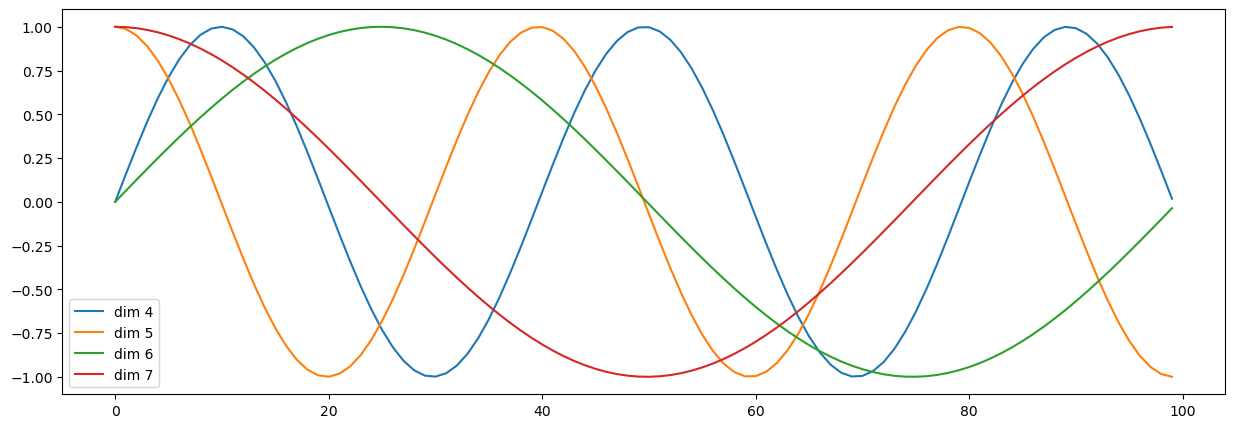

In [1]:
import pandas as pd
import torch
import torch.cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from vocabulary import Vocabulary
from torch.optim import Adam
import os
import numpy as np
# import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import input_model
from statistics import mean
"""
Load data
"""
data = pd.read_csv('./data/antibody/processed_data/VCR01.csv')

vocabulary = Vocabulary.get_vocabulary_from_sequences(data.sequence.values)  #将蛋白质序列构造成词典


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"




In [2]:
df_opt = data.copy()
# create an test/training set only from the training set
# assign to training or test set
df_opt["Set2"] = "eval"
training_ = df_opt.sample(frac=0.75, random_state=1)
df_opt.loc[training_.index, "Set2"] = "training"

df_training = df_opt[df_opt["Set2"]=="training"]
df_eval = df_opt[df_opt["Set2"]=="eval"]

In [3]:
def transform(sequence, max_len):
    tensor = vocabulary.seq_to_tensor(sequence)
    if len(tensor)>max_len:
        tensor = tensor[: max_len]
        tensor[-1] = 22
        list = tensor.numpy().tolist()
    else:
        list = tensor.numpy().tolist()+[0]*(max_len-len(tensor))
    return list

In [4]:
class Dataset(Dataset):
    def __init__(self, train=True):
        train_data = df_training.sequence.values
        eval_data = df_eval.sequence.values
        train_label = df_training.IC50.values
        eval_label = df_eval.IC50.values
        self.data = train_data if train else eval_data
        self.label = train_label if train else eval_label
        
    def __getitem__(self, index):
        #获取内容
        sequence = self.data[index]
        sequence = transform(sequence, 914)
        #获取label
        label = self.label[index]
        return sequence, label
    
    def __len__(self):
        return len(self.data)

In [5]:
def collate_fn(batch):
    sequence, label = zip(*batch)
    content = [i for i in sequence]
    content = torch.LongTensor(content)
    label = torch.FloatTensor(label)
    return content, label

In [6]:
def get_dataloader(train=True):
    dataset = Dataset(train)
    data_loader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
    return data_loader

In [7]:
for index, (input, target) in enumerate(get_dataloader()):
    print(index)
    print(input)
    print(target)
    break

0
tensor([[21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ...,  0,  0,  0],
        ...,
        [21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ...,  0,  0,  0],
        [21, 11, 15,  ...,  0,  0,  0]])
tensor([1.2200e+00, 4.0000e-01, 1.2900e-01, 8.4200e-01, 9.2000e-02, 6.6000e-01,
        2.0000e+01, 3.9820e+00, 6.0000e-01, 4.3000e-01, 8.0500e-01, 6.0000e-02,
        7.4510e+00, 2.0000e+01, 4.6800e-01, 2.0000e+01, 3.3000e-01, 2.0000e+01,
        4.5100e-01, 1.0000e+02, 1.5100e-01, 5.0000e+01, 7.8000e-02, 1.5900e+00,
        9.8000e-02, 4.0000e-03, 7.2600e-01, 4.4110e+00, 1.6800e-01, 2.0000e+01,
        6.0000e-02, 8.4000e-01, 5.1000e-01, 5.0000e-02, 5.1780e+00, 1.7400e-01,
        1.2500e-01, 8.6000e-01, 1.6000e-01, 6.6000e-02, 5.8300e-01, 5.1000e-02,
        1.5700e-01, 1.0000e+02, 2.7000e-01, 8.4000e-01, 2.9000e-01, 2.0000e+01,
        2.0000e+01, 1.5800e-01, 4.9400e-01, 1.7700e-01, 1.0000e-01, 6.9700e-01,
        4.0000e+01, 7.16

In [8]:
# 定义Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        # Embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Transformer编码器
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout),
            num_layers
        )
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # Transformer编码器
        x = self.encoder(x)
        
        # 平均池化
        x = torch.mean(x, dim=1)
        
        # 输出层
        x = self.output_layer(x)
        return x



In [9]:
# 设置超参数
input_size = 1000  # 输入序列的词汇大小
output_size = 1  # 输出的数值大小
hidden_size = 256  # 隐藏层大小
num_layers = 4  # Transformer编码器的层数
num_heads = 8  # 注意力头的数量
dropout = 0.2  # Dropout率
batch_size = 32  # 批处理大小
num_epochs = 1000  # 训练轮数
learning_rate = 0.001  # 学习率


In [10]:
# 创建模型和优化器
model = TransformerModel(input_size, output_size, hidden_size, num_layers, num_heads, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
if os.path.exists("./model/pickles/model.pkl"):
    model.load_state_dict(torch.load("./model/pickles/model.pkl"))
    optimizer.load_state_dict(torch.load("./model/pickles/optimizer.pkl"))



In [11]:
# 训练模型
loss_item = []
for epoch in range(300):
    loss_list = []
    for index, (input, target) in enumerate(get_dataloader()):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(input)
        
        # 计算损失
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        if index%100 == 0:
            torch.save(model.state_dict(), "./model/pickles/model.pkl")
            torch.save(optimizer.state_dict(), "./model/pickles/optimizer.pkl")
    loss_item.append(round(mean(loss_list), 2))
    print("第{}个epoch, mean_loss:{}".format(epoch+1, round(mean(loss_list), 2)))
    
    

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


第1个epoch, mean_loss:410.77
第2个epoch, mean_loss:388.95
第3个epoch, mean_loss:377.56
第4个epoch, mean_loss:336.75
第5个epoch, mean_loss:447.52
第6个epoch, mean_loss:377.2
第7个epoch, mean_loss:343.38
第8个epoch, mean_loss:340.46
第9个epoch, mean_loss:372.43
第10个epoch, mean_loss:388.74
第11个epoch, mean_loss:343.94
第12个epoch, mean_loss:380.97
第13个epoch, mean_loss:396.88
第14个epoch, mean_loss:395.56
第15个epoch, mean_loss:358.4
第16个epoch, mean_loss:356.3
第17个epoch, mean_loss:343.45
第18个epoch, mean_loss:335.98
第19个epoch, mean_loss:348.08
第20个epoch, mean_loss:372.76
第21个epoch, mean_loss:346.98
第22个epoch, mean_loss:355.96
第23个epoch, mean_loss:410.6
第24个epoch, mean_loss:340.68
第25个epoch, mean_loss:426.31
第26个epoch, mean_loss:384.49
第27个epoch, mean_loss:403.21
第28个epoch, mean_loss:335.57
第29个epoch, mean_loss:344.52
第30个epoch, mean_loss:350.8
第31个epoch, mean_loss:381.77
第32个epoch, mean_loss:339.95
第33个epoch, mean_loss:335.77
第34个epoch, mean_loss:380.84
第35个epoch, mean_loss:372.8
第36个epoch, mean_loss:343.68
第37个epo

In [12]:
loss_item

[410.77,
 388.95,
 377.56,
 336.75,
 447.52,
 377.2,
 343.38,
 340.46,
 372.43,
 388.74,
 343.94,
 380.97,
 396.88,
 395.56,
 358.4,
 356.3,
 343.45,
 335.98,
 348.08,
 372.76,
 346.98,
 355.96,
 410.6,
 340.68,
 426.31,
 384.49,
 403.21,
 335.57,
 344.52,
 350.8,
 381.77,
 339.95,
 335.77,
 380.84,
 372.8,
 343.68,
 356.37,
 389.81,
 375.03,
 351.55,
 419.81,
 343.16,
 383.35,
 343.31,
 383.33,
 335.53,
 373.55,
 386.24,
 424.9,
 414.13,
 418.99,
 348.41,
 373.59,
 396.49,
 447.18,
 351.97,
 350.79,
 342.16,
 410.31,
 399.51,
 448.4,
 388.87,
 374.17,
 348.88,
 374.32,
 447.43,
 359.67,
 433.13,
 381.09,
 351.88,
 380.37,
 336.18,
 417.24,
 380.51,
 343.0,
 335.9,
 419.94,
 374.01,
 410.24,
 343.53,
 395.67,
 343.86,
 345.89,
 380.18,
 392.86,
 343.1,
 373.02,
 381.5,
 335.65,
 372.13,
 379.79,
 381.16,
 417.13,
 351.5,
 372.44,
 418.08,
 381.78,
 340.42,
 373.62,
 411.63,
 342.62,
 373.42,
 418.59,
 350.62,
 380.45,
 392.58,
 484.87,
 347.47,
 341.56,
 355.24,
 336.19,
 355.05,
 426.

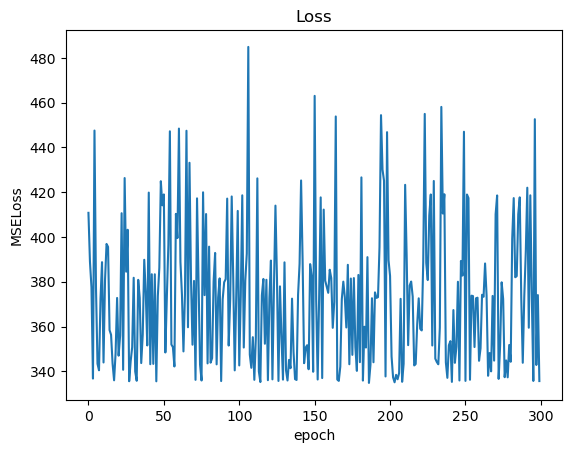

In [14]:
# 绘制loss曲线
import matplotlib.pyplot as plt
import numpy as np

y = np.array(loss_item)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("MSELoss")
plt.plot(y)
plt.show()